# Using the Web: Curvenam.es and Modelr.io

We'll try getting some geoscience info from the web.

The usual prelims:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll use the `requests` library, because it's nicer to use than `urllib2`. 

In [2]:
import requests

## Curvenam.es

[`curvenam.es`](http://curvenam.es) is a little web app for looking up curve mnemonics from LAS files.

Here's what [the demo request from the site](http://curvenam.es/lookup) looks like:

    http://curvenam.es/lookup?mnemonic=TEST&method=fuzzy&limit=5&maxdist=2
    
We split this into the URL, and the query parameters:

In [3]:
url = 'http://curvenam.es/lookup'

In [4]:
params = {'mnemonic': 'DT4P',
          'method': 'fuzzy',
          'limit': 1,
          'maxdist': 2
         }

In [5]:
r = requests.get(url, params)

If we were successful, the server sends back a `200` status code:

In [6]:
r.status_code

200

The result of the query is in the `text` attribute of the result:

In [7]:
r.text

'{"mnemonic": "DT4P", "maxdist": "2", "limit": "1", "result": [{"mnemonic": "DT4P", "distance": 0, "curve": {"mnemonic": "DT4P", "model": "", "unittype": "AcousticSlowness", "description": "Delta-T Compressional - Monopole P&S", "units": "", "company": "Schlumberger", "type": "Curve", "method": "Wireline"}}], "time": 0.010610103607177734, "method": "fuzzy"}'

There's a convenient `json()` method to give us the result as JSON:

In [8]:
r.json()

{'limit': '1',
 'maxdist': '2',
 'method': 'fuzzy',
 'mnemonic': 'DT4P',
 'result': [{'curve': {'company': 'Schlumberger',
    'description': 'Delta-T Compressional - Monopole P&S',
    'method': 'Wireline',
    'mnemonic': 'DT4P',
    'model': '',
    'type': 'Curve',
    'units': '',
    'unittype': 'AcousticSlowness'},
   'distance': 0,
   'mnemonic': 'DT4P'}],
 'time': 0.010610103607177734}

So we can get a result back like so:

In [9]:
try:
    print(r.json()['result'][0]['curve']['description'])
except:
    print("No results")

Delta-T Compressional - Monopole P&S


## The modelr API

Some small demos of the modelr API, hurriedly compiled. 

In [10]:
from PIL import Image
from io import BytesIO
from base64 import b64decode

### Request a wedge synthetic

Let's build the request programmatically. 

In [11]:
url = 'https://www.modelr.org/plot.json'

params = { 'script': 'wedge_spatial.py',
           'theta': 0,
           'f': 25,
           'colourmap': 'Greys',
           'opacity': 0.5,
           'tslice': 150,
           'scale': '1.0,99',
           'base1': 'variable-density',
           'Rock0': '3000.0,1600.0,2500.0,50.0,50.0,50.0',
           'Rock1': '2770.0,1780.0,2185.0,50.0,50.0,50.0',
           'Rock2': '3000.0,1600.0,2500.0,50.0,50.0,50.0',
           'type': "scenario"
         }

I don't know why `requests` doesn't like our certificate, but it fails if we don't suppress cert verification. I am checking into this.

In [12]:
r = requests.get(url, params, verify=False)

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [13]:
idata = b64decode(r.json()['data'])
i = Image.open(BytesIO(idata))

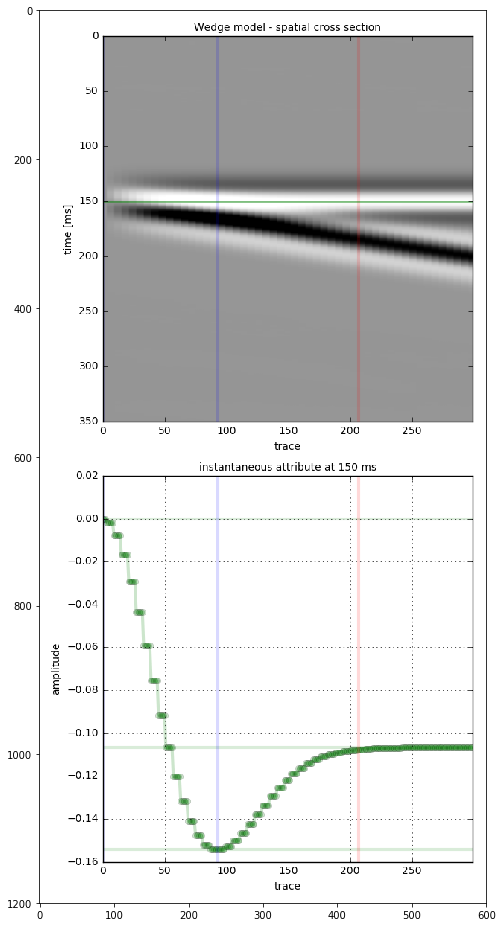

In [14]:
plt.figure(figsize=(8,18))
plt.imshow(i)
plt.show()

### Model building

The model-building URL is displayed in modelr, on the page https://www.modelr.io/model_builder (subscription only).

Here's an example of a URL call againt the model-building endpoint:

https://www.modelr.org/plot.json?script=slab_builder.py&interface_depth=80&x_samples=350&margin=50&left=0%2C40&right=30%2C130&layers=3&type=model_builder

This URL returns a JSON containing only a base64-encoded PNG — the model of the earth.

Let's look at some actual code.

In [15]:
url = 'https://www.modelr.org/plot.json'

params = { 'script': 'slab_builder.py',
           'interface_depth': 80,
           'x_samples': 350,
           'margin': 50,
           'left': '0,40',
           'right': '30,130',
           'layers': 3,
           'type': "model_builder"
         }

In [16]:
r = requests.get(url, params, verify=False)

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [17]:
data = r.json()['data']
idata = b64decode(data)

In [18]:
i = Image.open(BytesIO(idata))

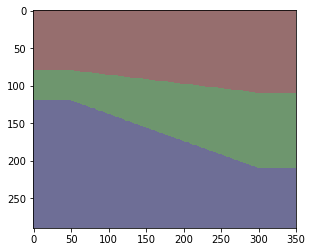

In [19]:
plt.imshow(i)
plt.show()

### Forward model

Actually... I don't think there's an easy way to do this right now.

We really need to be able to do the following:

- Make a 2D or 3D wedge model
- Send that model back with some seismic parameters and get a synthetic back
- Get the synthetic, or part of it, as a SEG-Y


In [20]:
params = {
  'earth_model': {
       'domain': 'time',
       'theta': [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
       'zrange': 1000,
       'image': data,
       'image_key': None,
       'mapping': {
            'rgb(110,110,150)': {
                'db_key': None,
                'description': 'none',
                'fluid': None,
                'kclay': 25000000000,
                'kqtz': 37000000000,
                'name': 'Hard shale',
                'phi': 0.2,
                'rho': 2750,
                'rho_std': 50,
                'vclay': 0.5,
                'vp': 5000,
                'vp_std': 50,
                'vs': 3165,
                'vs_std': 50},
            'rgb(110,150,110)': {
                'db_key': None,
                'description': 'None',
                'fluid': {
                    'db_key': None,
                    'description': 'description',
                    'k_hc': 200000000,
                    'k_w': 2200000000,
                    'name': 'Gas',
                    'rho_hc': 250,
                    'rho_w': 250,
                    'sw': 0.3},
                'kclay': 25000000000,
                'kqtz': 37000000000,
                'name': 'Sand (Gas filled)',
                'phi': 0.2,
                'rho': 2070,
                'rho_std': 50,
                'vclay': 0.5,
                'vp': 1650,
                'vp_std': 50,
                'vs': 1090,
                'vs_std': 50},
            'rgb(150,110,110)': {
                'db_key': None,
                'description': 'description',
                'fluid': None,
                'kclay': 25000000000,
                'kqtz': 37000000000,
                'name': 'Soft shale',
                'phi': 0.2,
                'rho': 2340,
                'rho_std': 50,
                'vclay': 0.5,
                'vp': 3240,
                'vp_std': 50,
                'vs': 1620,
                'vs_std': 50
            }
        },
    },
    'offset': 1,
    'trace': 1,
    'seismic': {
        'dt': 0.001,
        'frequency': 20.72462090190231,
        'phase': 0,
        'snr': 50,
        'wavelet': 'ricker'
    }
}

In [21]:
import json
j = json.dumps(params)

In [22]:
r = requests.get(url, j, verify=False)

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [23]:
r.status_code

400

Damn.